# Weather in Australia

In [1]:
#!pip install geopy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # Plot with missing data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from geopy.geocoders import Nominatim

In [3]:
df = pd.read_csv('weatherAUS.csv')

# EDA

## Business goal

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Analyzing this data table, we can presume that our business goal is to determine whether it will rain tomorrow. Our response variable will be the data from the "RainTomorrow" column, while the explanatory variables will be the remaining columns. 

Response: 
    RainTomorrow: The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".
    
Explanatory: 
    Date: The date of observation
    Location: The common name of the location of the weather station
    MinTem: The minimum temperature in degrees celsius
    MaxTemp: The maximum temperature in degrees celsius
    Rainfall: The amount of rainfall recorded for the day in mm
    Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
    Sunshine: The number of hours of bright sunshine in the day.
    WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
    WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
    WindDir9am: Direction of the wind at 9am
    WindSpeed9am: Wind speed (km/hr) averaged over 10 minutes prior to 9am
    WindSpeed3pm: Wind speed (km/hr) averaged over 10 minutes prior to 3pm
    Humidity9am: Humidity (percent) at 9am
    Humidity3pm: Humidity (percent) at 3pm
    Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
    Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
    Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas"
    Cloud3pm: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm
    Temp9am: Temperature (degrees C) at 9am
    Temp3pm: Temperature (degrees C) at 3pm
    RainToday: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
    


## Data analysis and vizualization

Numerical and categorical values

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
categorical= df.select_dtypes(include=['object']).columns
print("Categorical: ", list(categorical))

numerical = df.select_dtypes(include=['number']).columns
print("Numerical: ", list(numerical))

Categorical:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
Numerical:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


Statistics

In [7]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


Stats vizualization

array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Evaporation'}>],
       [<Axes: title={'center': 'Sunshine'}>,
        <Axes: title={'center': 'WindGustSpeed'}>,
        <Axes: title={'center': 'WindSpeed9am'}>,
        <Axes: title={'center': 'WindSpeed3pm'}>],
       [<Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>,
        <Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>],
       [<Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>,
        <Axes: title={'center': 'Temp9am'}>,
        <Axes: title={'center': 'Temp3pm'}>]], dtype=object)

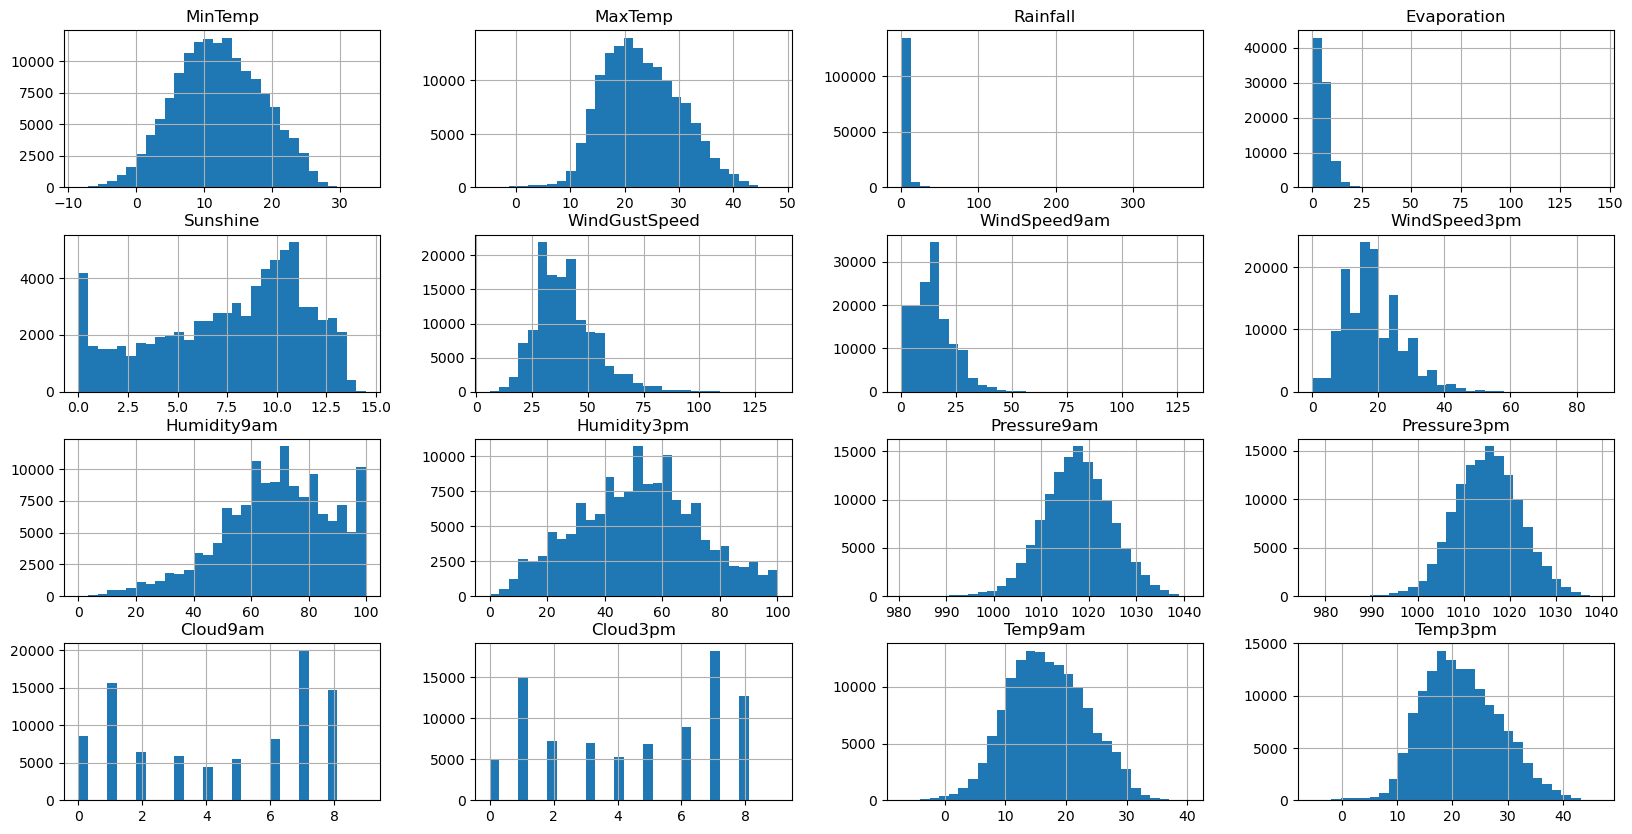

In [8]:
df.hist(figsize=(20, 10), bins=30)  

We want to identify the correlation with missing values and later again without them.

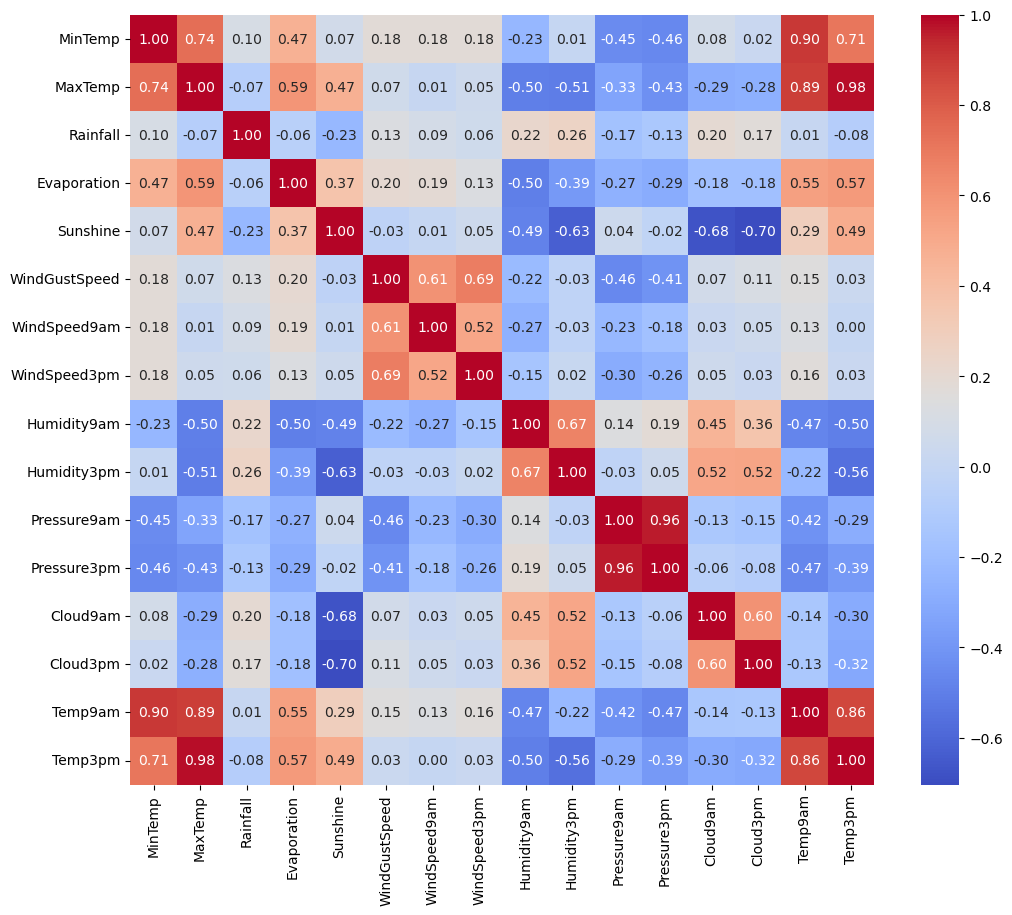

In [9]:
nan_numerical_df = df.select_dtypes(include=['number'])
nan_correlation_matrix = nan_numerical_df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(nan_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

## Missing Values and Anomalies

### Missing Values

Handling missing values - RainTomorrow an RainToday. Those are binary values and it is hard to replace them with other values.

In [10]:
df.dropna(axis=0, subset=['RainToday','RainTomorrow'], inplace=True) 

How many missing values do we have?

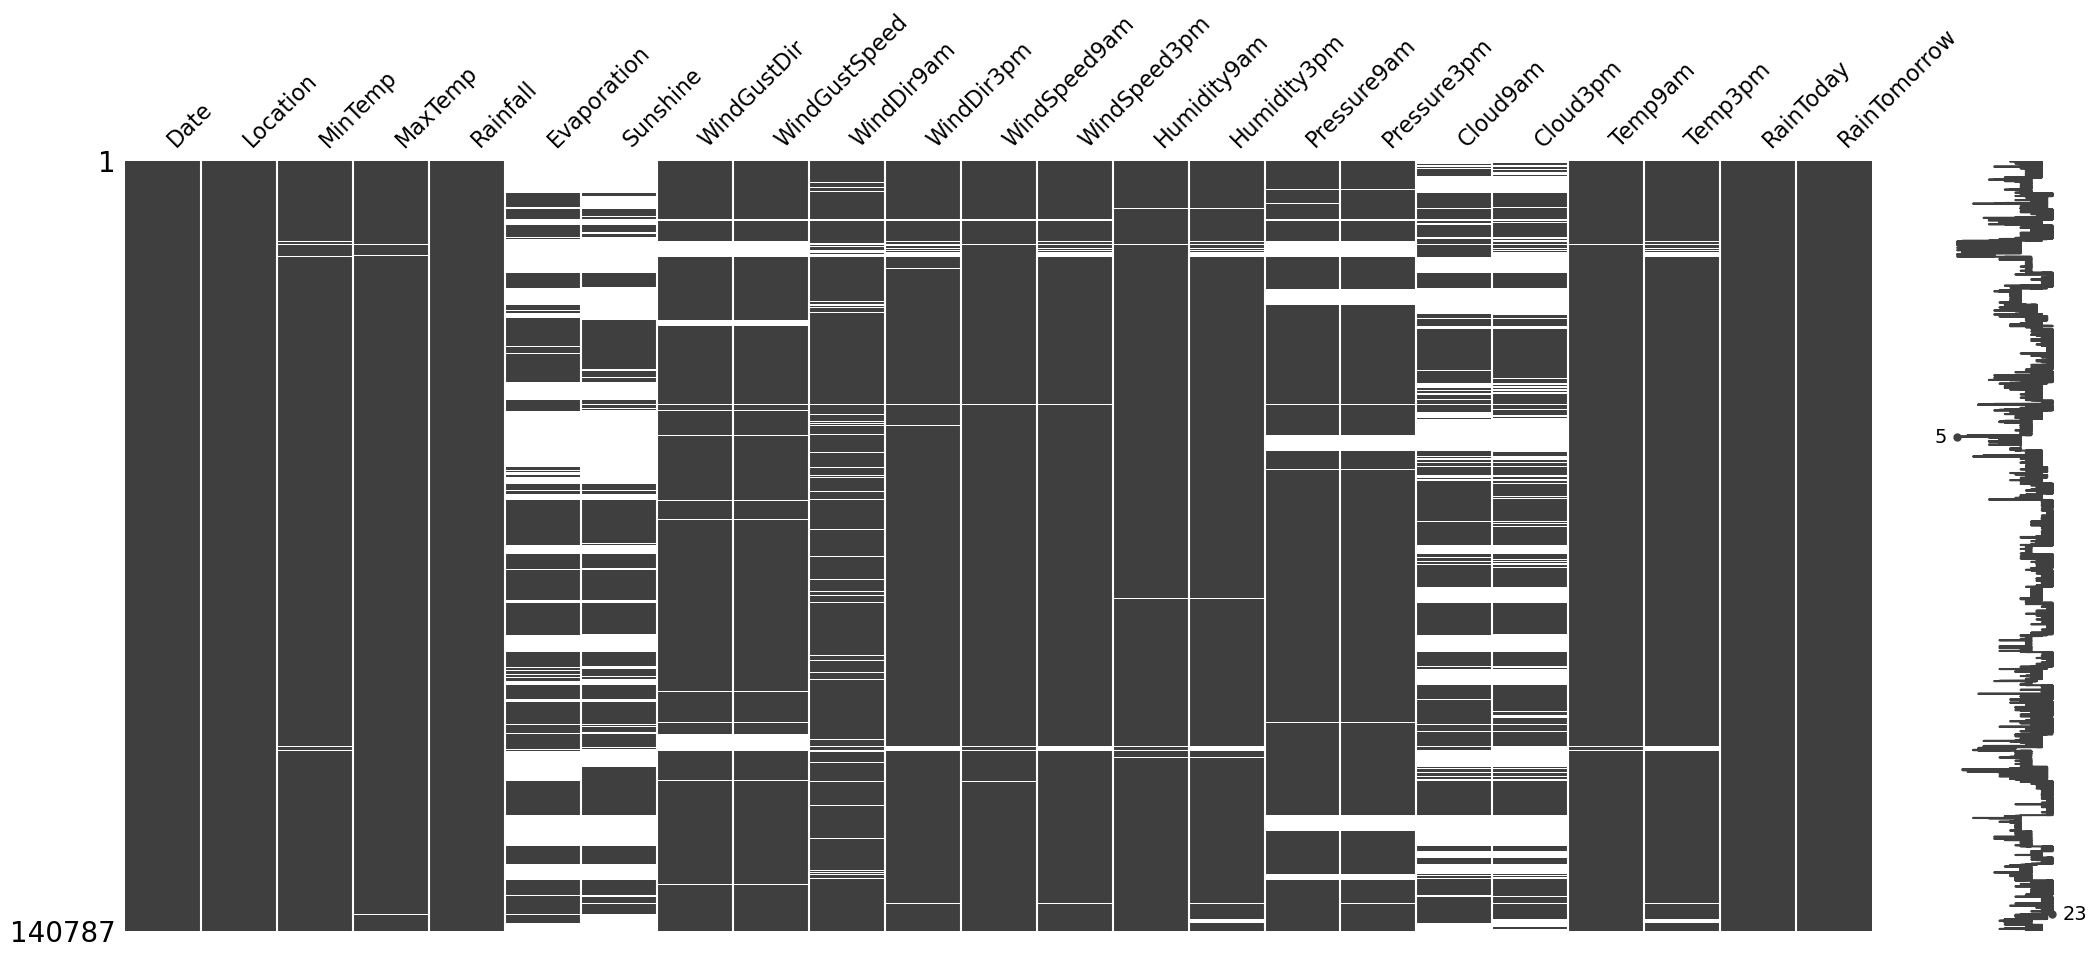

In [11]:
# Plot shows missing values
msno.matrix(df)
plt.show()

In [12]:
#Function for making stats about missing values
def missing(dataframe):
    total = dataframe.isnull().sum()
    percent = round(dataframe.isnull().sum()/len(df)*100, 2)
    missing = pd.concat([percent,total], axis=1, keys=['Percent','Total']).sort_values(by = ['Percent'], ascending = False).T
    return missing

Stats about missng values

In [13]:
missing(df)

,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,WindDir9am,WindGustDir,WindGustSpeed,WindDir3pm,...,Humidity9am,WindSpeed9am,Temp9am,MinTemp,MaxTemp,RainToday,Date,Location,Rainfall,RainTomorrow
Percent,47.45,42.4,39.84,37.38,9.78,9.76,6.86,6.51,6.47,2.61,...,1.08,0.75,0.47,0.33,0.22,0.0,0.0,0.0,0.0,0.0
Total,66805.00,59694.0,56094.00,52625.00,13769.00,13743.00,9660.00,9163.00,9105.00,3670.00,...,1517.00,1055.00,656.00,468.00,307.00,0.0,0.0,0.0,0.0,0.0


Adding new column with a month for better dealing with missing values

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12


### Handling missing categorical values

In [15]:
df_with_missing = df.copy()

In [16]:
df_with_missing.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12


In [17]:
print(df.columns)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month'],
      dtype='object')


In [18]:
# Handling categorical missing values ('WindGustDir', 'WindDir9am', 'WindDir3pm'). We want to replace them in each location with mode.
modes = df[categorical[2:5]].apply(pd.Series.mode).to_dict("list")
modes = {i:modes[i][0] for i in modes}

df_cat = df[categorical].dropna()
loc_cat = df_cat.groupby(['Location'])[categorical[2:5]].agg(pd.Series.mode)
del df_cat
print(loc_cat.shape[0], df.Location.nunique())
loc_cat.T
# We can see two Locations missing, taht means they contain only NaN values in at least one column.

47 49


Location,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,...,ENE,NW,E,ENE,SE,N,WNW,SSE,NE,SSE
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,...,SE,NW,E,E,NW,ENE,WNW,SE,SW,SE
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,...,ENE,NW,E,WSW,SSE,SSW,SE,SSE,NE,SSW


In [19]:
missing_locations = list(set(df.Location.unique().tolist()) - set(loc_cat.index.tolist()))
print(missing_locations)
# We will replace NaN in those locations with mode values for whole data frame (counted higher), where there is a need.

['Newcastle', 'Albany']


In [20]:
for loc in missing_locations:
    x = df[df['Location'] == loc][categorical[2:5]].apply(pd.Series.mode)
    x.fillna(modes, inplace = True)
    x.index = [loc]
    loc_cat = pd.concat([loc_cat, x], axis = 0)
loc_cat.T

,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,Newcastle,Albany
WindGustDir,WSW,W,ESE,E,N,SSE,E,SE,NW,SW,...,E,ENE,SE,N,WNW,SSE,NE,SSE,W,W
WindDir9am,NNE,SE,ESE,SW,N,SSE,SW,SSE,NNW,NE,...,E,E,NW,ENE,WNW,SE,SW,SE,NW,NW
WindDir3pm,WSW,W,ESE,"[E, NNE]",N,N,ENE,SE,WNW,SW,...,E,WSW,SSE,SSW,SE,SSE,NE,SSW,SE,ESE


In [21]:
# Now we have proper dimensions
loc_cat.shape

(49, 3)

In [22]:
for l in df.Location.unique():  
    if l not in loc_cat.index:
        continue  

    indices = df[df['Location'] == l].index
    for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        value = loc_cat.loc[l, col]
        
        if isinstance(value, (np.ndarray, list)) and len(value) > 0:
            value = value[0]  
        
        if not isinstance(value, (str, int, float)):
            value = np.nan  
        
        df.loc[indices, col] = df.loc[indices, col].fillna(value)
        loc_cat.loc[l, col] = value  

### Handling missing numerical values

There are many missing numerical values 

In [23]:
df.isnull().sum().sum()

284494

In [24]:
# Average value for each (Location, Month) combination
loc_month_num = df.groupby(['Location', 'Month'])[df.columns[df.isnull().any()]].mean()

# Average for a given month (regardless of location)
month_num = df.groupby('Month')[df.columns[df.isnull().any()]].mean()



In [25]:
for l in df.Location.unique():
    for m in df.Month.unique():
        indices = df[(df['Location'] == l) & (df['Month'] == m)].index
        available_nan = df.columns[df.isnull().any()]  

        for col in available_nan:
            try:
                # Retrieve the average for (Location, Month)
                value = loc_month_num.loc[(l, m), col]

                # If no data is available for the given location → use the average from other cities for the given month
                if pd.isna(value):
                    value = month_num.loc[m, col]  # Retrieve the average for the month (all cities)

                # If the value is a list, take the first element
                if pd.api.types.is_list_like(value):
                    value = value[0] if len(value) > 0 else np.nan  

                # Fill in missing values
                df.loc[indices, col] = df.loc[indices, col].fillna(value)

            except KeyError:
                continue

In [26]:
# There are no NaN hurayyyyy!!!
df.isnull().sum().sum()

0

Let's check if our method is correct.

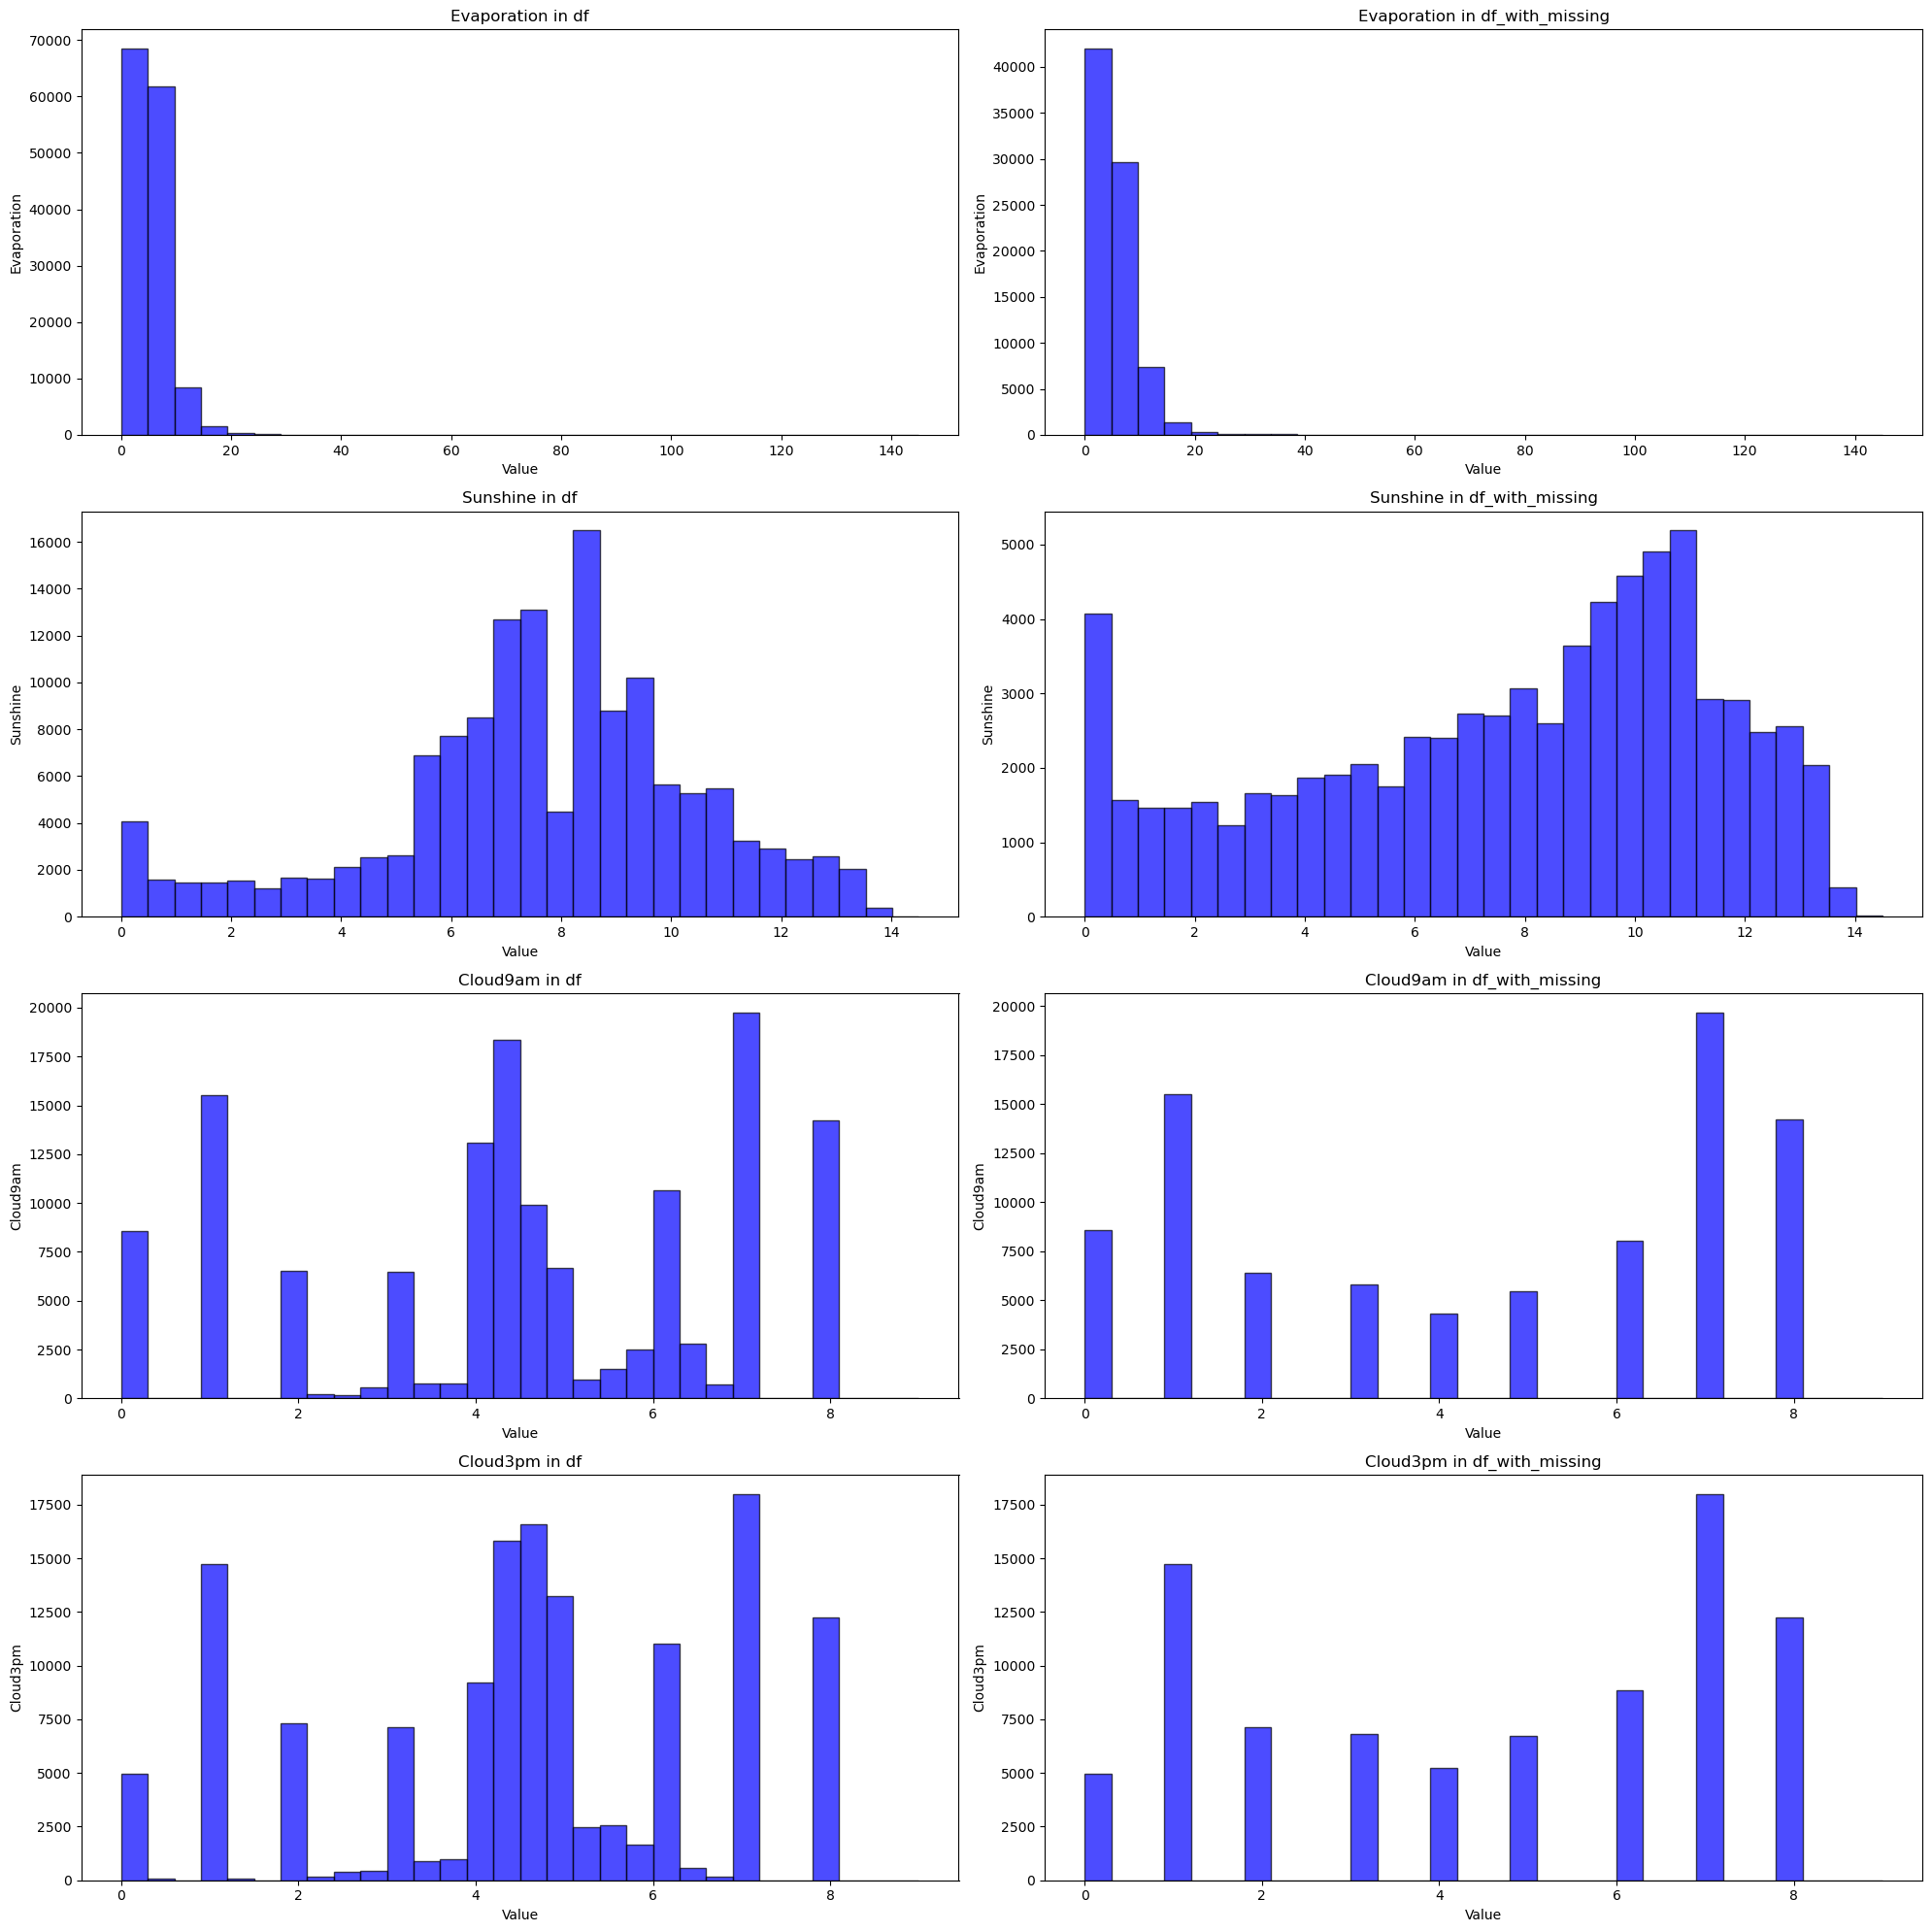

In [27]:
nan_columns = ['Evaporation','Evaporation', 'Sunshine', 'Sunshine','Cloud9am', 'Cloud9am','Cloud3pm', 'Cloud3pm']

n_rows = 4
n_cols = 2

dfs = [df, df_with_missing]
df_names = ['df', 'df_with_missing']  

plt.figure(figsize=(20, 20))

for i, column in enumerate(nan_columns):
    current_df = dfs[i % 2]  
    current_df_name = df_names[i % 2] 
    plt.subplot(n_rows, n_cols, i + 1)  
    plt.hist(current_df[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{column} in {current_df_name}')
    plt.xlabel('Value')
    plt.ylabel(column)

plt.tight_layout()
plt.show() 

### Test KNNImputer - K Nearest Neighbours

In [28]:
df2 = df_with_missing.copy()

df2.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12


In [29]:
# from sklearn.impute import KNNImputer

# #df2 = df2.head(30000)
# df2 = df2.iloc[40000:70000]

# numerical_cols = [col for col in df2.select_dtypes(include=['float64', 'int64']).columns 
#                            if df2[col].isnull().any()]

# imputer = KNNImputer(n_neighbors=3)

# imputed_data = imputer.fit_transform(df2[numerical_cols])

# imputed_df = pd.DataFrame(imputed_data, columns=numerical_cols, index=df2.index)

# df2[numerical_cols] = imputed_df

# print(df2.head(100))

In [30]:
#print(df2[numerical_cols].isnull().sum())
df2


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,6
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,6
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,6
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,6


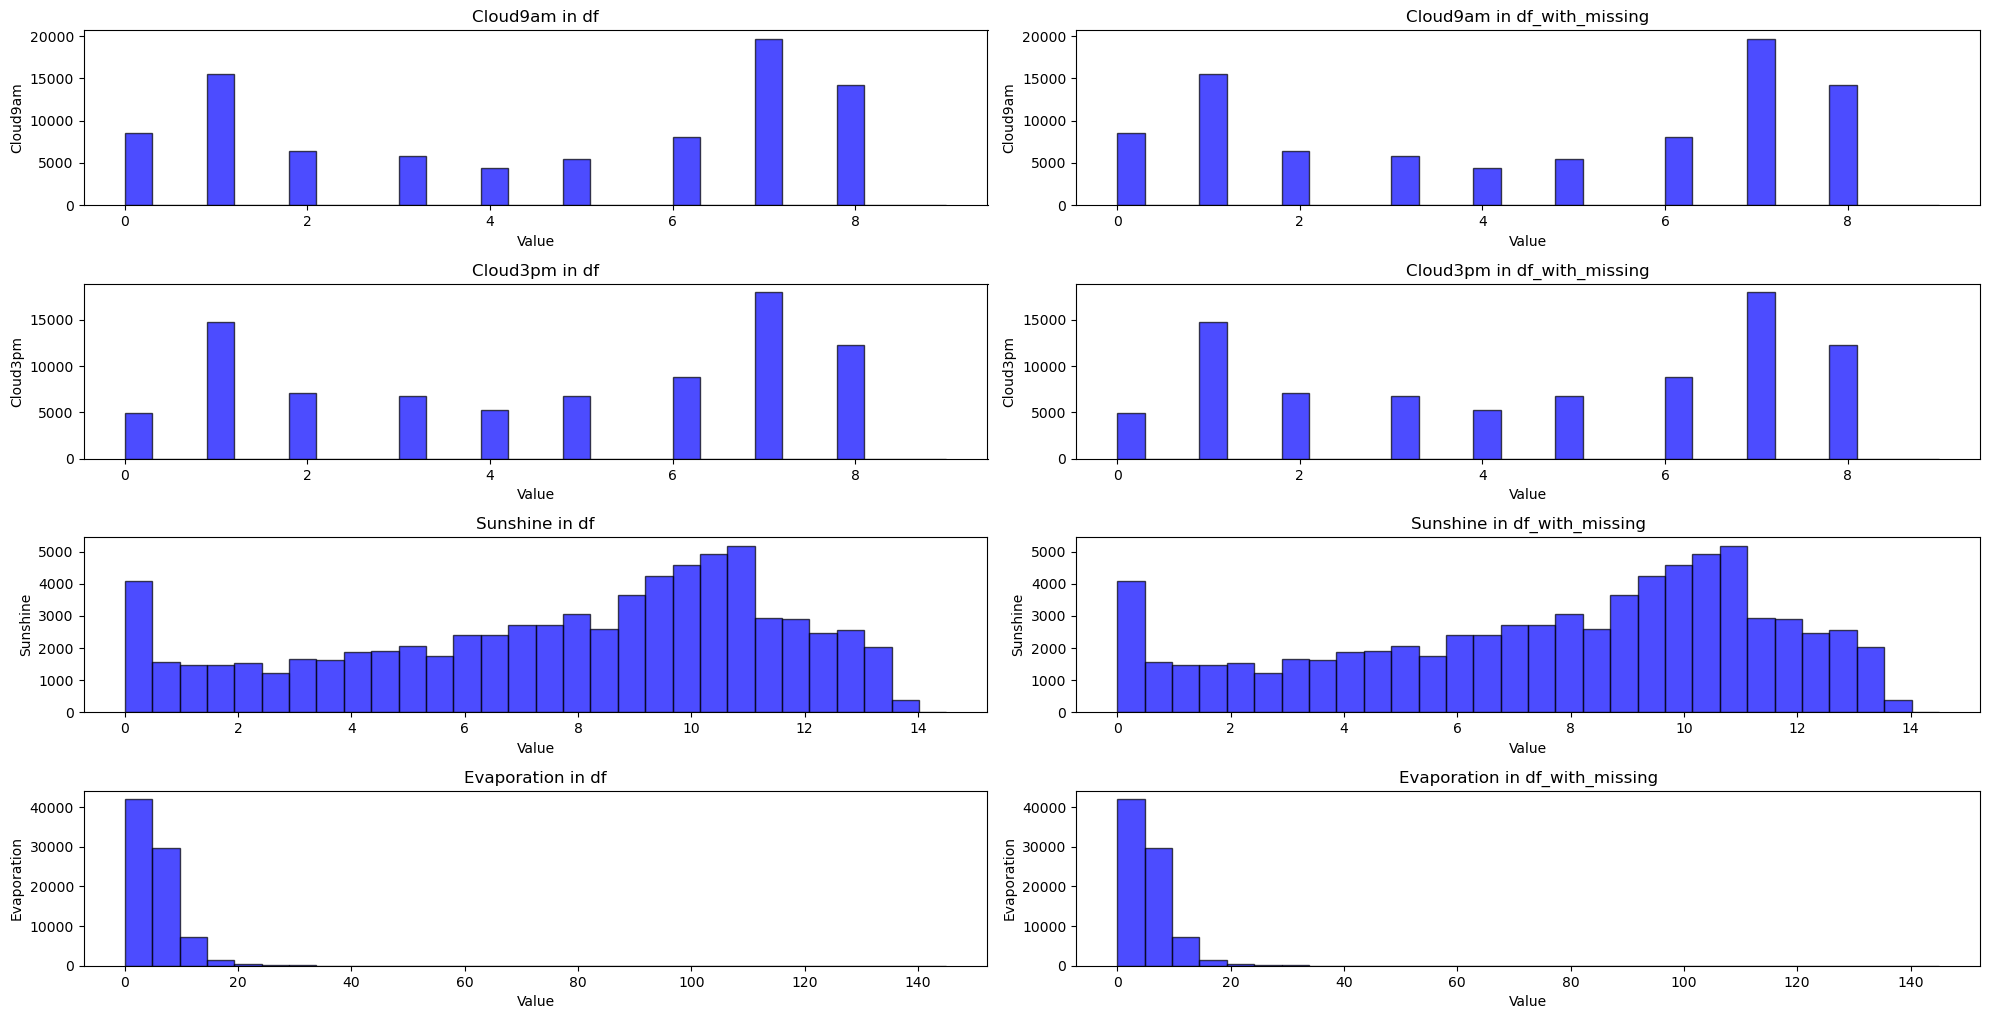

In [31]:
nan_columns = ['Cloud9am', 'Cloud9am','Cloud3pm', 'Cloud3pm','Sunshine', 'Sunshine', 'Evaporation', 'Evaporation']

n_rows = 8
n_cols = 2

dfs2 = [df2, df_with_missing]
df_names = ['df', 'df_with_missing']  

plt.figure(figsize=(20, 20))

for i, column in enumerate(nan_columns):
    current_df = dfs2[i % 2]  
    current_df_name = df_names[i % 2] 
    plt.subplot(n_rows, n_cols, i + 1)  
    plt.hist(current_df[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{column} in {current_df_name}')
    plt.xlabel('Value')
    plt.ylabel(column)

plt.tight_layout()
plt.show() 

### Dependencies between variables

We want to identify where the boxplots show significant differences - potentially have a stronger influence on the rain the next day. Thanks to them, we can see that the weather conditions definitely have an impact on the next day's rain.
We can see that larger differences occur in humidity, pressure, and temperature during later hours, which will be important later.

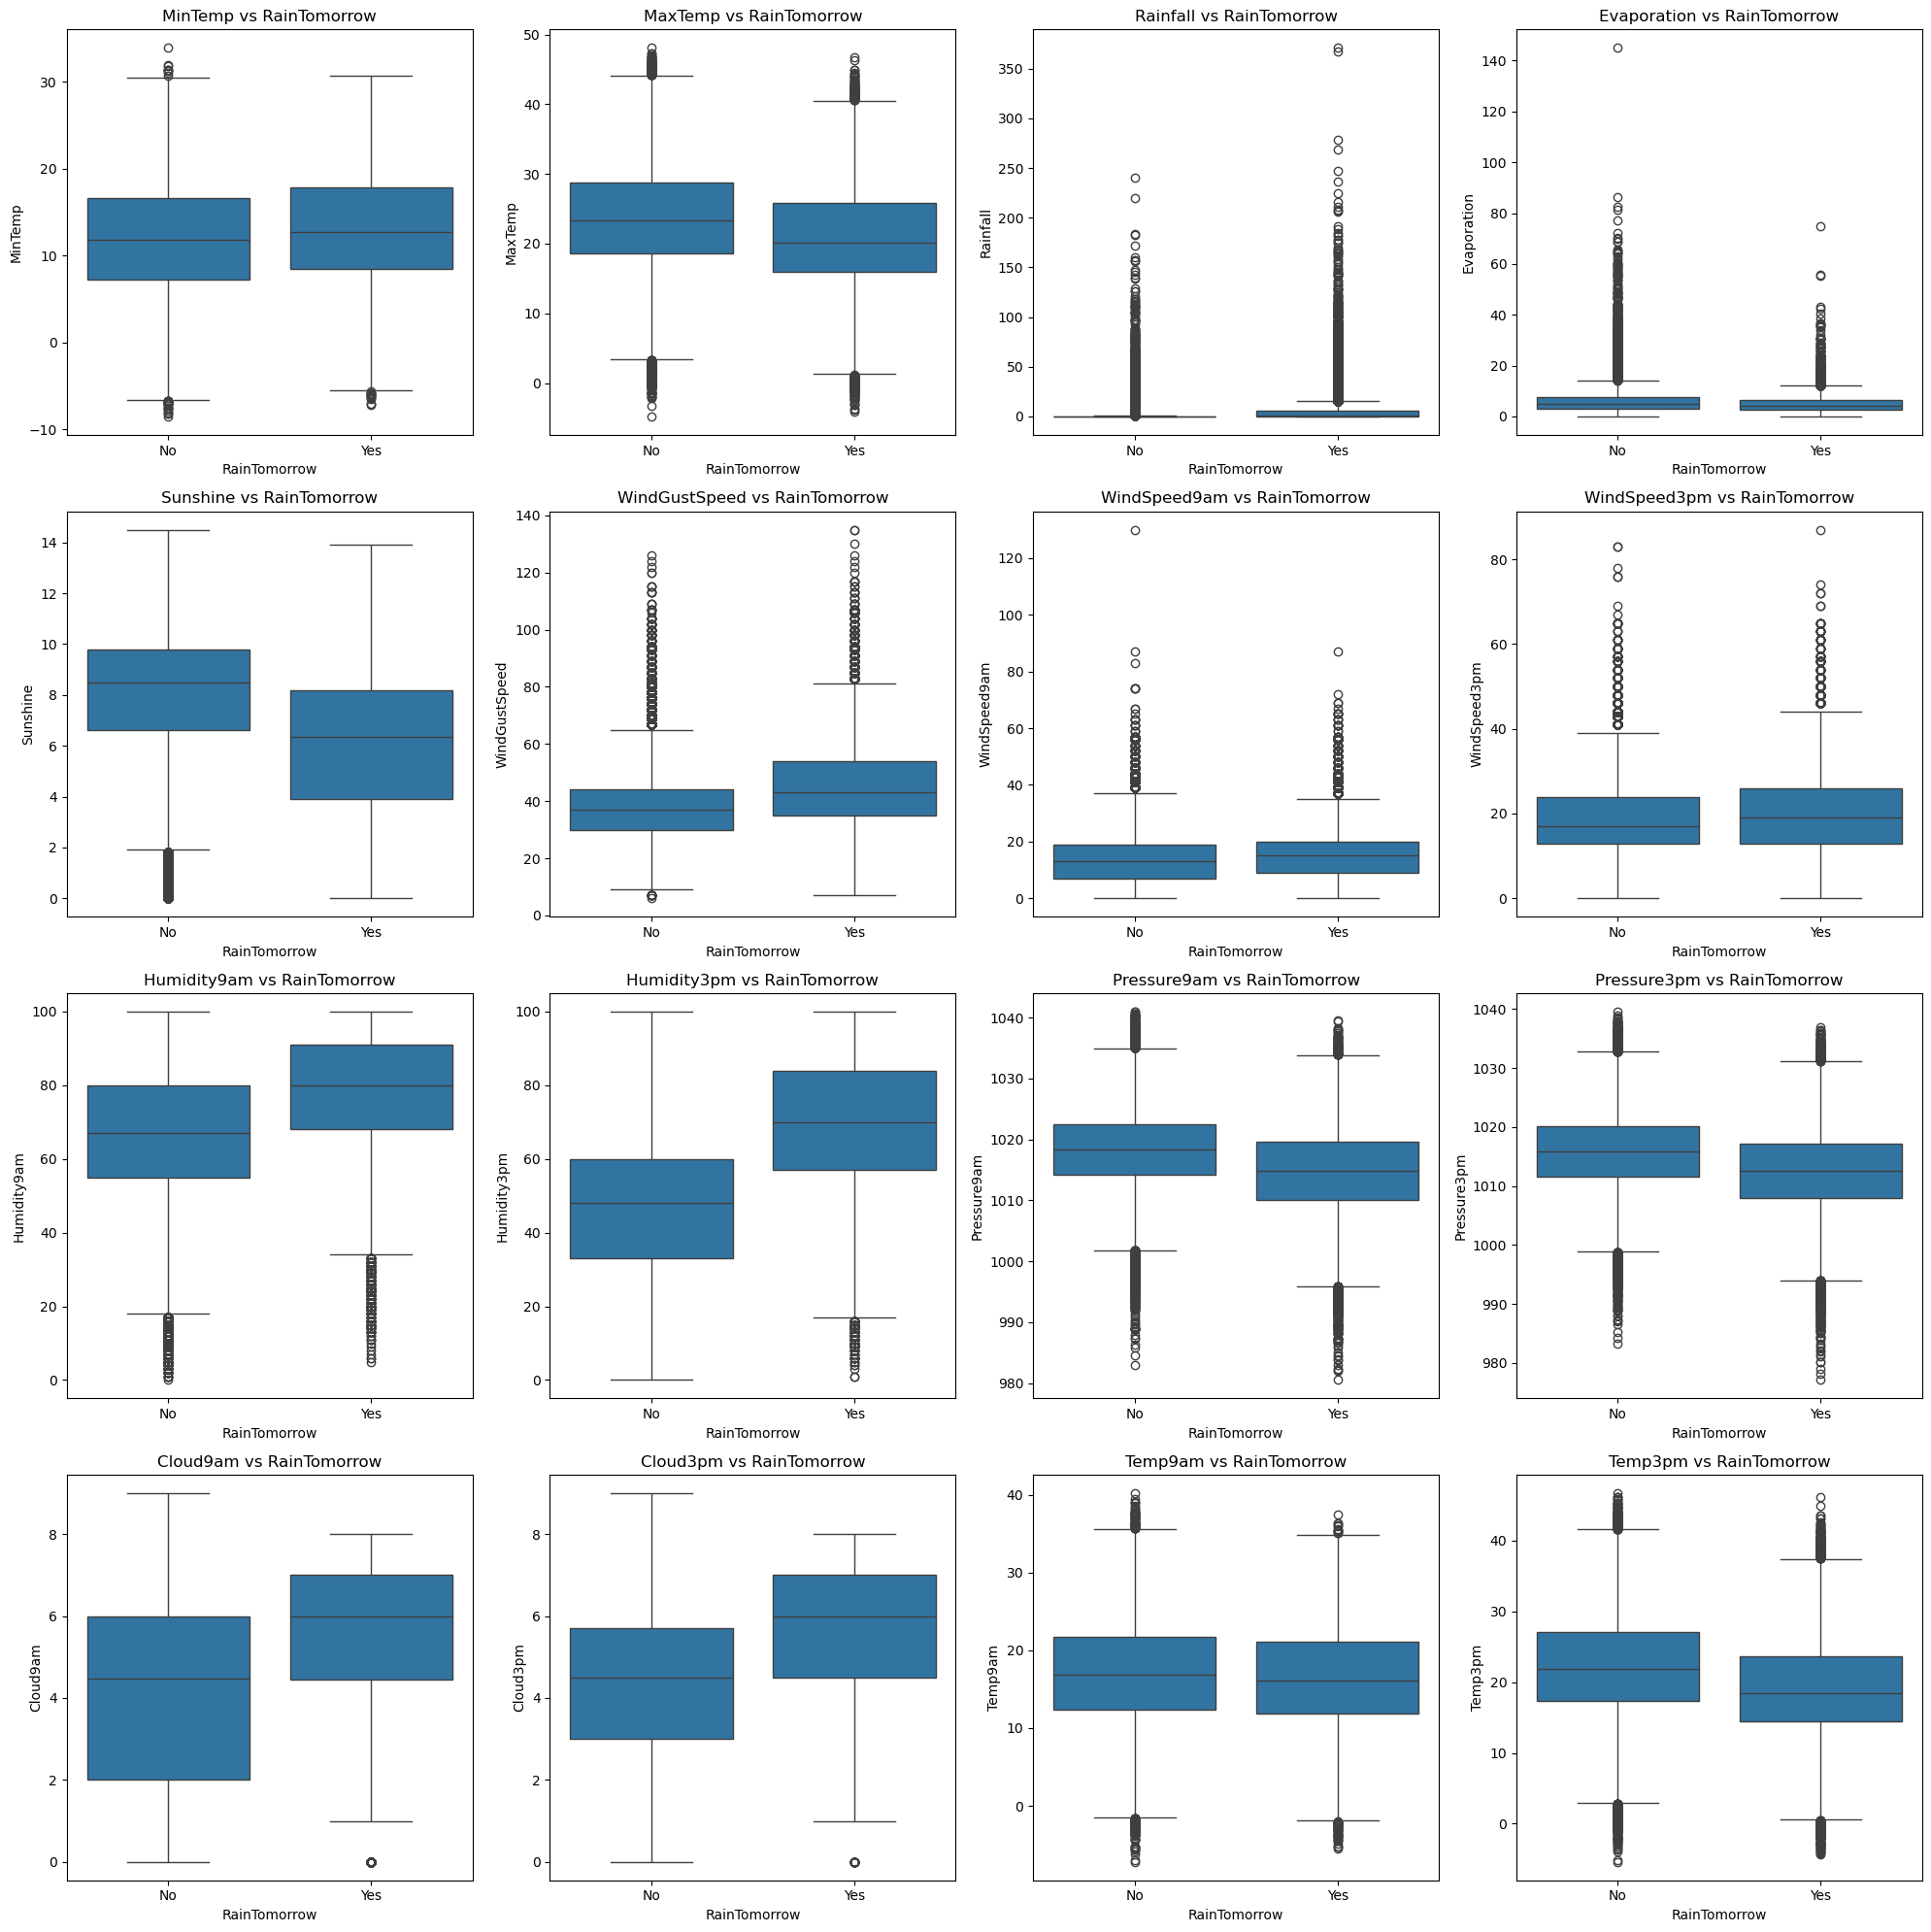

In [32]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                     'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
n_rows = 4
n_cols = 4

plt.figure(figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### Outliers

From previous plots we can see that there are many outliers, we decide to logarithm some of them them in order reduce their influence.

In [33]:
df['Rainfall'] = np.log1p(df['Rainfall'])  
df['Evaporation'] = np.log1p(df['Evaporation'])
df['WindGustSpeed'] = np.log1p(df['WindGustSpeed'])
df['WindSpeed9am'] = np.log1p(df['WindSpeed9am'])  
df['WindSpeed3pm'] = np.log1p(df['WindSpeed3pm'])


For other columns we decide to relace outliers that ar over 3σ with 3σ. 

In [34]:
sigma_numerical = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Temp9am', 'Temp3pm']

def replace_outliers(df, num_cols, threshold=3):
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

df = replace_outliers(df, sigma_numerical)

We want to check what change.

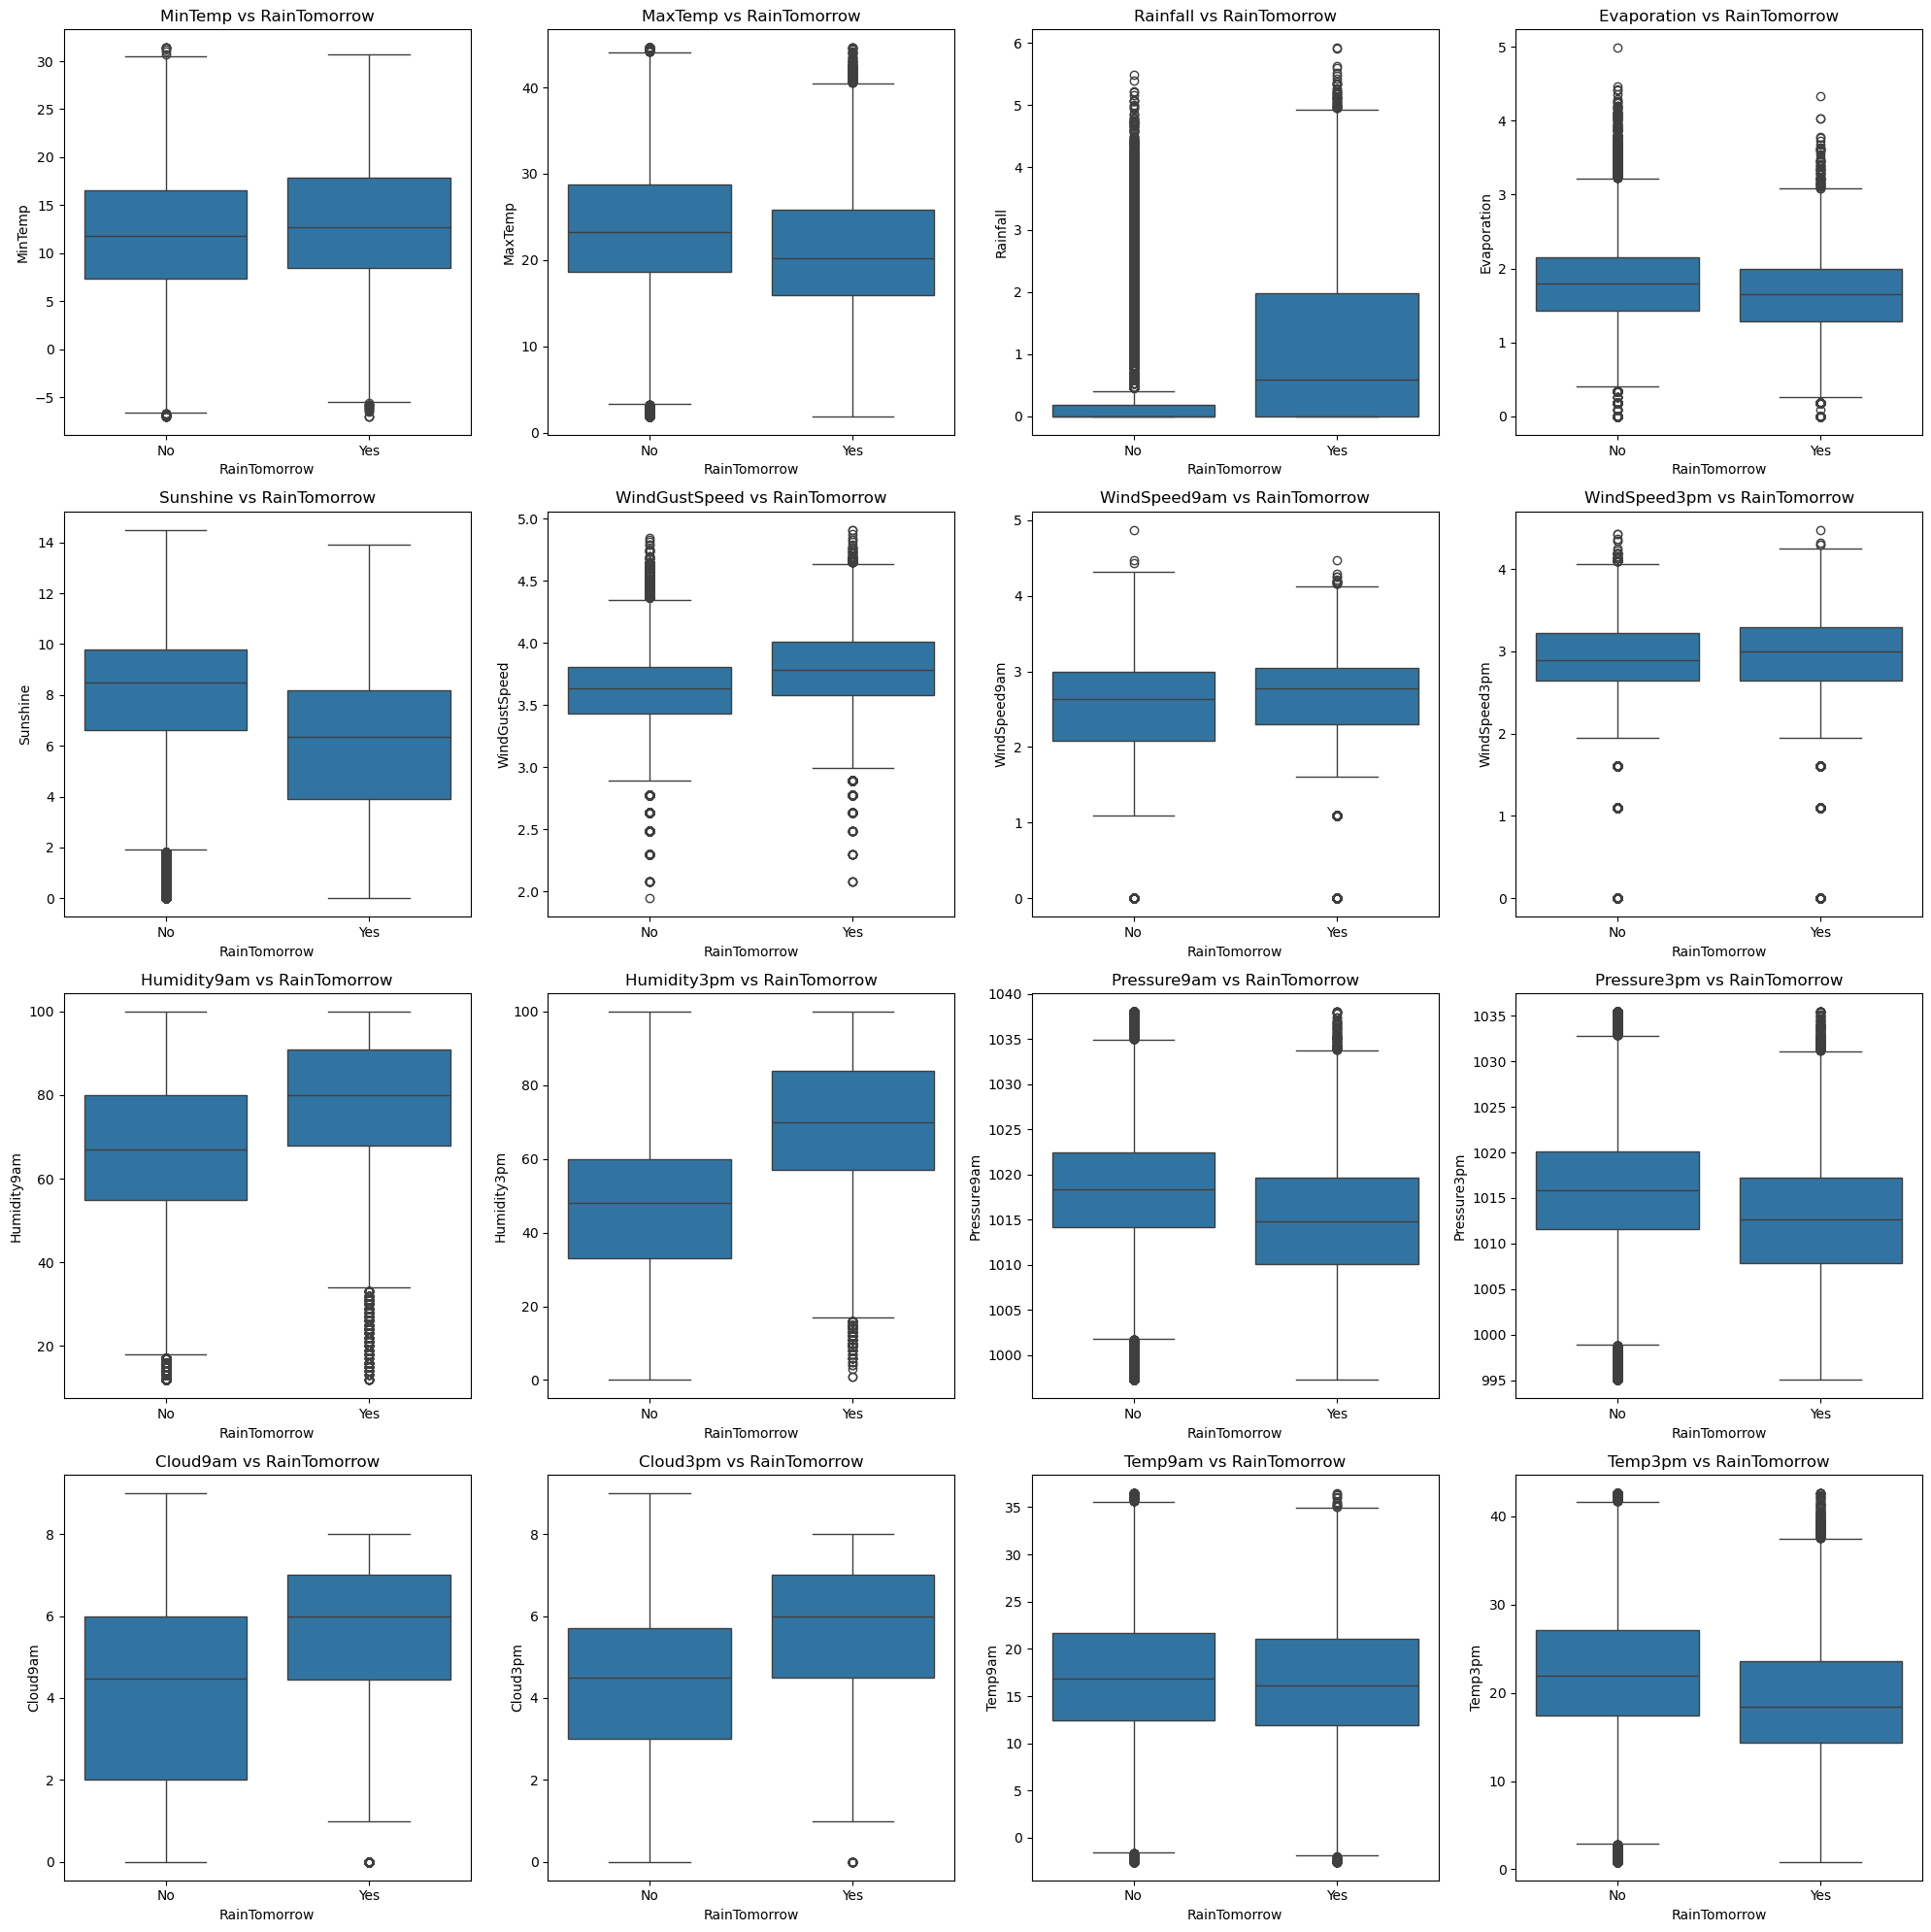

In [35]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                     'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
n_rows = 4
n_cols = 4

plt.figure(figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

The correlation between some factors is probably very high. For example temperature:

In [36]:
#sns.pairplot(data=df, vars=('MaxTemp','MinTemp','Temp9am','Temp3pm'), hue='RainTomorrow')
#plt.show()

And a very similar situation with pressure:

In [37]:
#sns.pairplot(data=df, vars=('Pressure9am', 'Pressure3pm'), hue='RainTomorrow')
#plt.show()

But for example the correlation is not so high for wind and humidity:

In [38]:
#sns.pairplot(data=df, vars=('WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm'), hue='RainTomorrow')
#plt.show()

Now we are sure that we should combine some columns - MaxTemp with Temp3pm, MinTemp with Temp9am, Pressure together
So maybe a mean? However, from the boxplots, we saw that later hours had a greater impact, so we will take them into account.

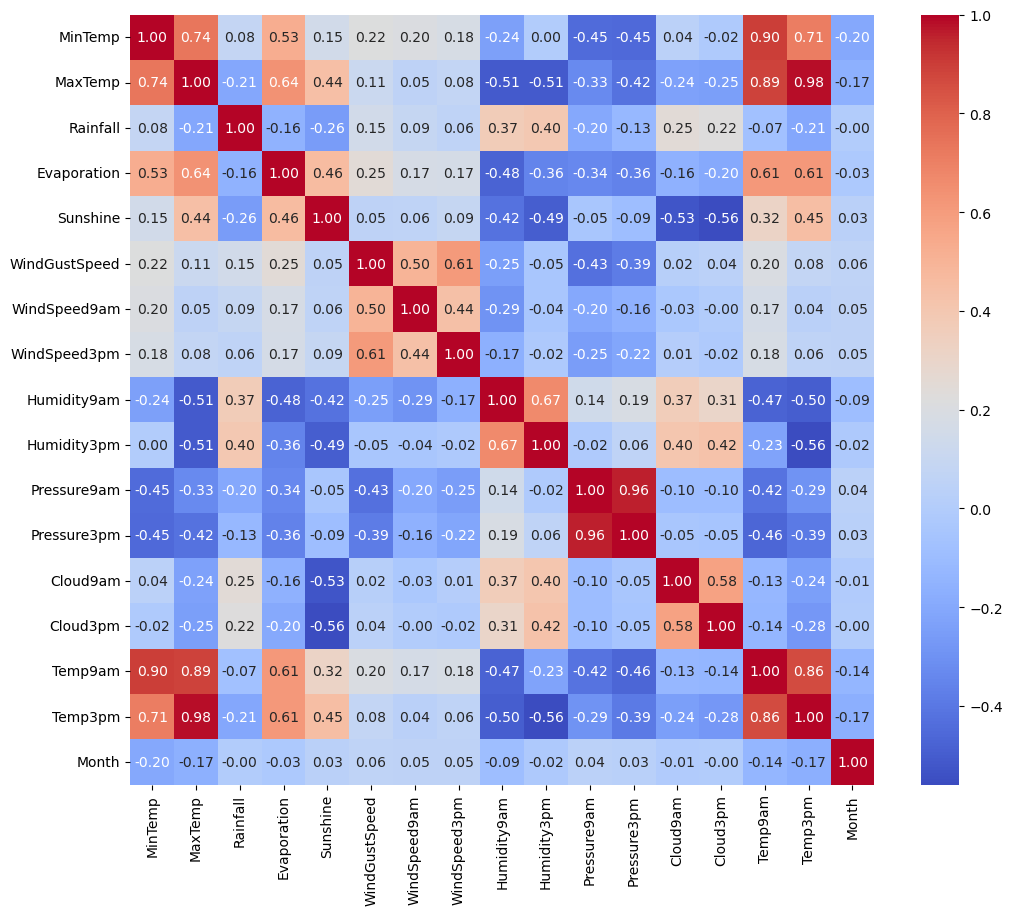

In [39]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()


We would also like to check what is the correlation of each parameter to TomorrowRain. To do that we have to change te type of some columns. 

In [40]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month'],
      dtype='object')

In [41]:
# Conversion of Rain columns to 0/1
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

num_cols = df.select_dtypes(include=['float64']).columns

# Correlation with "RainTomorrow"
correlation = df[num_cols].corrwith(df['RainTomorrow']).sort_values(ascending=False)

correlation


Humidity3pm      0.443761
Rainfall         0.343700
Cloud3pm         0.299736
Humidity9am      0.257632
Cloud9am         0.244314
WindGustSpeed    0.204014
MinTemp          0.083696
WindSpeed9am     0.069155
WindSpeed3pm     0.053311
Temp9am         -0.027272
Evaporation     -0.112704
MaxTemp         -0.159286
Temp3pm         -0.191405
Pressure3pm     -0.213584
Pressure9am     -0.232638
Sunshine        -0.330387
dtype: float64

The deletion of these columns should help in predicting rain. 

# FEATURE ENGINEERING

The correlations between the temperature-related variables are very high, so we should combine these columns.
We will calculate the average of MaxTemp and Temp3pm. This decision is based on the insights from the boxplot, 
which indicates that these variables show significant variation depending on whether it rains the following day or not.

columns1 = ['MinTemp', 'MaxTemp','Temp9am', 'Temp3pm']
n_rows = 2
n_cols = 2

plt.figure(figsize=(20, 20))
for i, column in enumerate(columns1):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [42]:
df['AvgTemp'] = (df['MaxTemp'] + df['Temp3pm']) / 2

df = df.drop(columns=['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'])

The correlation between the pressure-related variables is 0.96, so we’ll combine these columns to avoid redundancy.

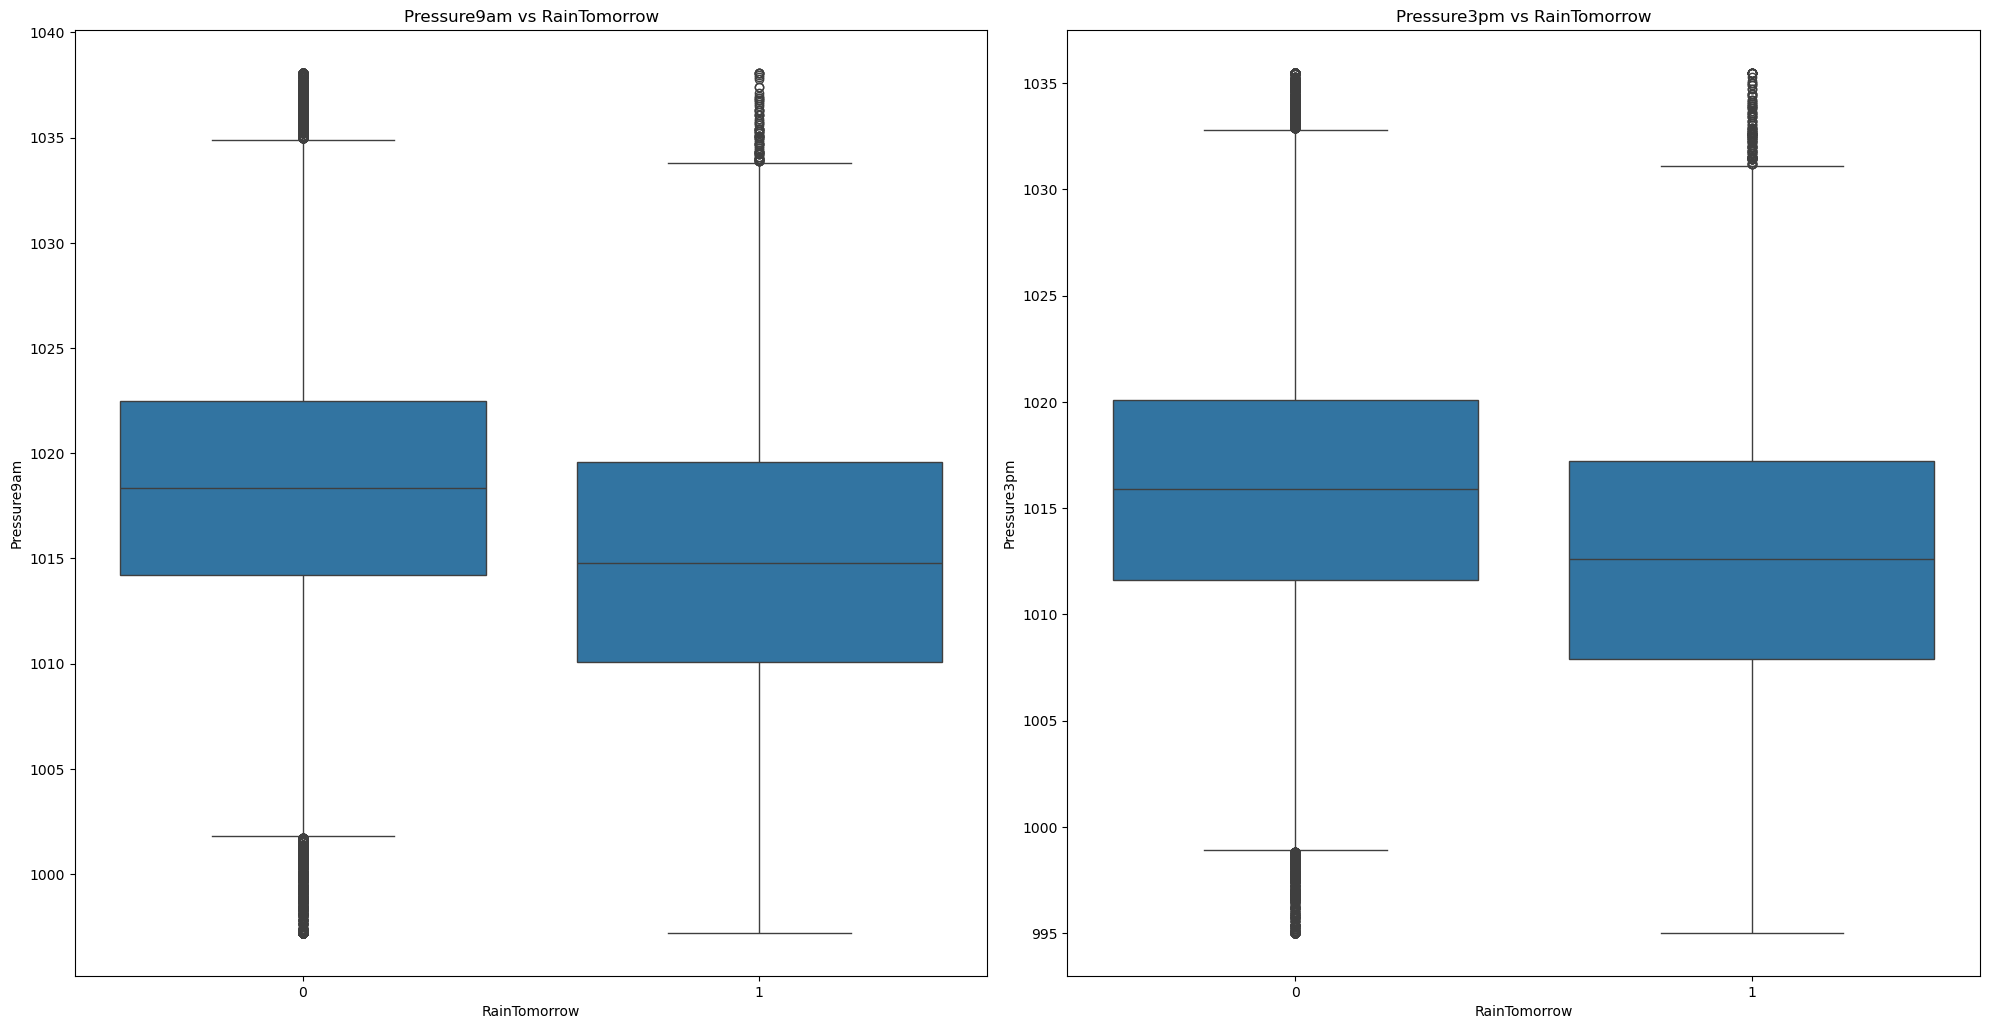

In [43]:
columns1 = ['Pressure9am', 'Pressure3pm']
n_rows = 2
n_cols = 2

plt.figure(figsize=(20, 20))
for i, column in enumerate(columns1):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

Since there are no significant differences in the boxplots, we’ll take the average of the pressure-related columns.

In [44]:
df['AvgPressure'] = (df['Pressure9am'] + df['Pressure3pm']) / 2

df = df.drop(columns=['Pressure9am', 'Pressure3pm'])

Now we have to do the same with wind speed.

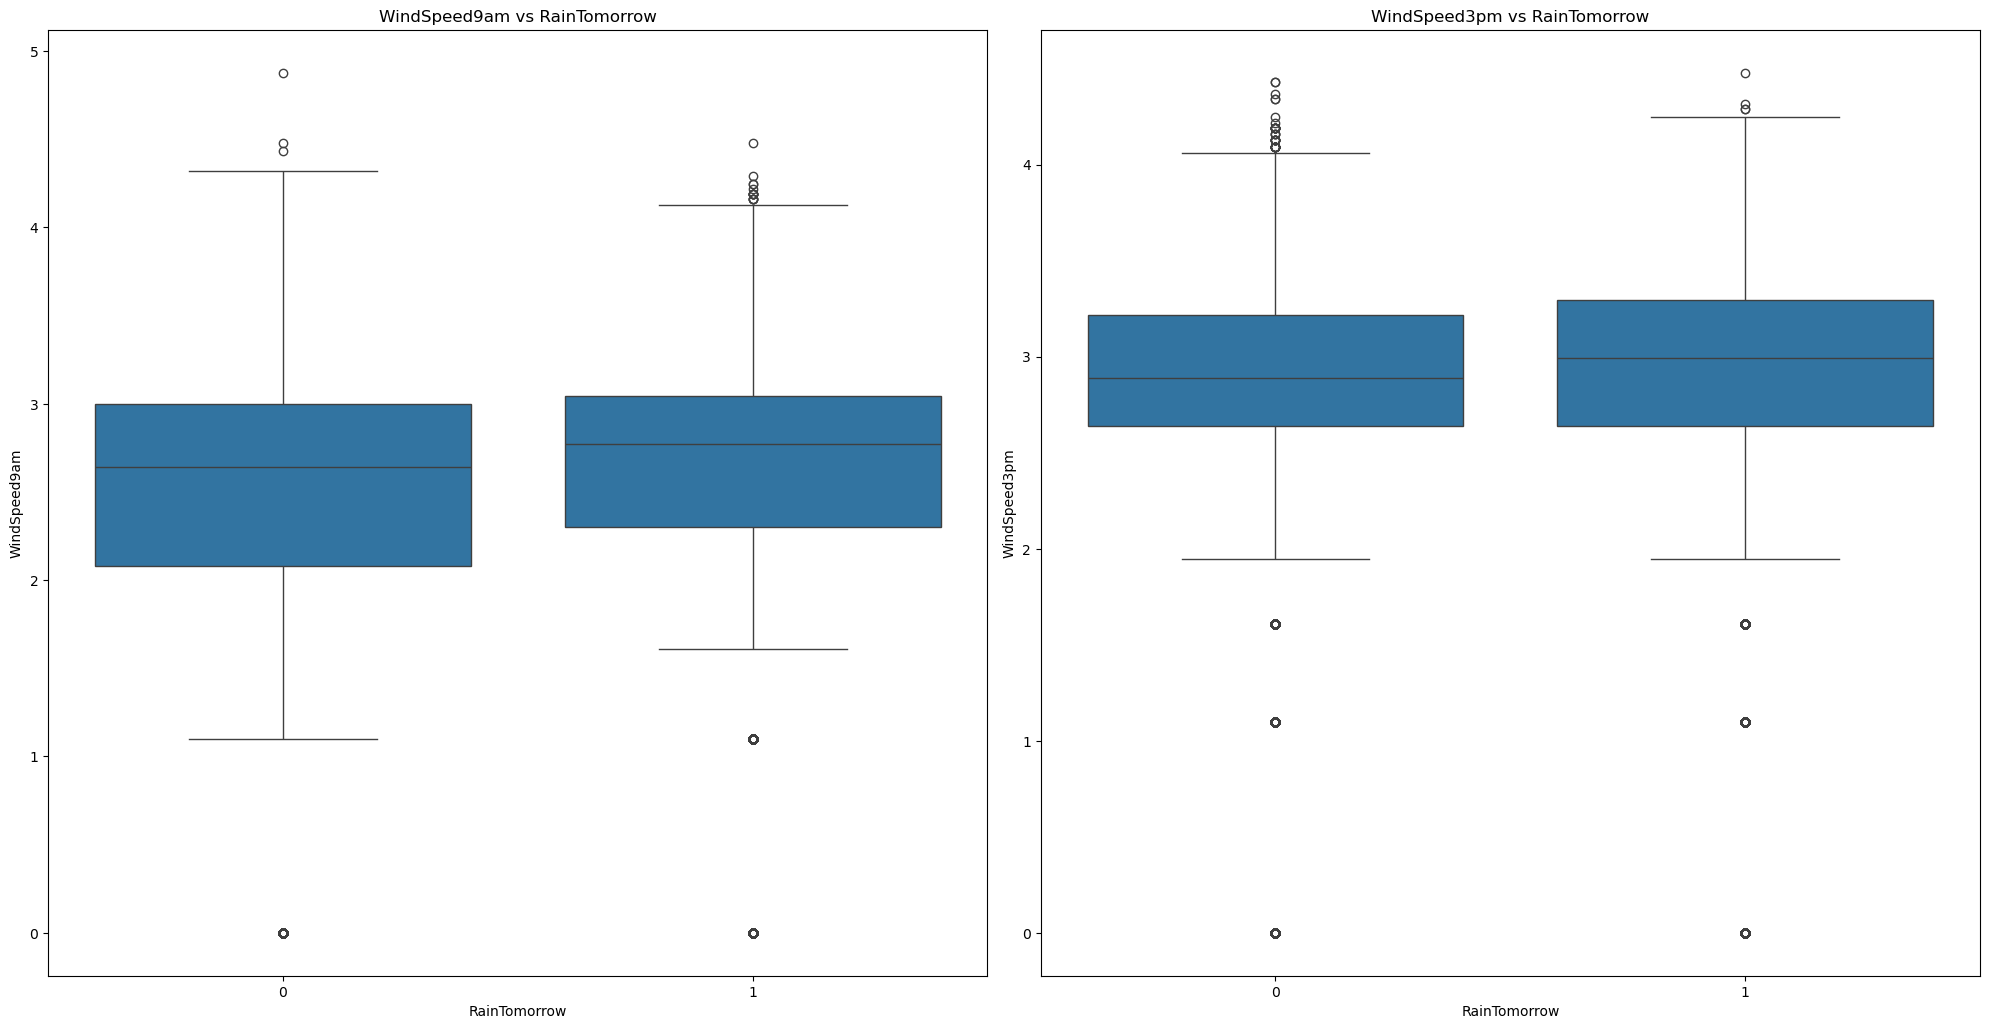

In [45]:
columns1 = ['WindSpeed9am', 'WindSpeed3pm']
n_rows = 2
n_cols = 2

plt.figure(figsize=(20, 20))
for i, column in enumerate(columns1):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [46]:
df['AvgWindSpeed'] = (df['WindSpeed9am'] + df['WindSpeed3pm']) / 2

df = df.drop(columns=['WindSpeed9am', 'WindSpeed3pm'])

Values in column months have range from 1 to 12. They have cyclic nature. We want to show that month 1 and month 12 are in reality close to each other. To do that we want to apply sine an cosine function on them. Combined they can properly show the correlation between months. 

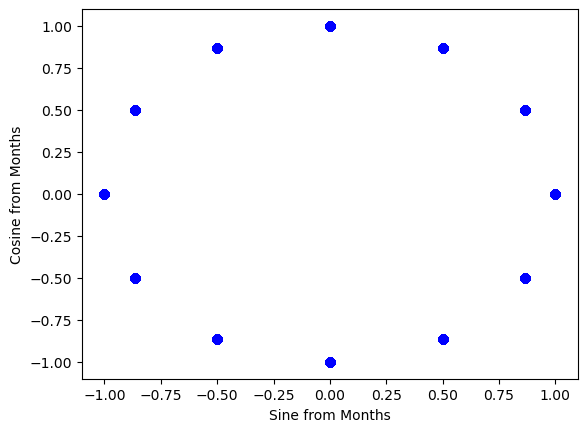

In [47]:
df['Month' + '_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month' + '_cos'] = np.cos(2 * np.pi * df['Month']/12)

plt.scatter(df['Month_sin'], df['Month_cos'], c = 'blue')
plt.ylabel("Cosine from Months")
plt.xlabel("Sine from Months")
plt.show()

In [48]:
df = df.drop(columns=['Month'])

We want to do similar thing with wind directions. It also has cyclic nature.

In [49]:
wind_map = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16
}

df[['WindGustDir','WindDir9am','WindDir3pm']] = df[['WindGustDir','WindDir9am','WindDir3pm']].map(lambda x: wind_map.get(x, None))

In [50]:
def switch(df, col):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/16)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/16)
    return df

In [51]:
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df = switch(df, col)

We decided that it would be the best to change names of locations for longitude and latitude. 

In [52]:
locations = df['Location']
print(locations.unique())

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


In [53]:
data = {
    "Location": ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Newcastle',
                  'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport',
                  'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong',
                  'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne',
                  'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
                  'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera',
                  'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums',
                  'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine',
                  'Uluru'],
    "Latitude": [-36.0800, -33.9200, -31.4989, -30.2963, -29.4618, -32.9267,
                 -33.2810, -29.0408, -33.7511, -33.6000, -33.8688, -33.9399,
                 -35.1150, -32.7900, -34.4278, -35.2809, -35.4167,
                 -35.5290, -37.5622, -36.7587, -38.1080, -37.6690, -37.8136,
                 -34.1855, -36.3333, -38.3496, -37.7167, -37.9167, -27.4698, -16.9186,
                 -28.0167, -19.2589, -34.9285, -37.8318, -34.4680, -31.1990,
                 -35.0228, -34.0167, -31.6670, -31.9403, -31.9505, -32.9833,
                 -34.9750, -42.8821, -41.4388, -23.6980, -12.4634, -14.4650,
                 -25.3444],
    "Longitude": [146.9200, 150.7400, 145.8339, 153.1135, 149.8410, 151.7817,
                  151.5760, 167.9544, 150.6940, 150.7500, 151.2093, 151.1753,
                  147.3670, 151.8350, 150.8931, 149.1300, 149.0833,
                  148.7720, 143.8503, 144.2820, 147.0680, 144.8410, 144.9631,
                  142.1625, 141.6500, 141.6057, 145.0833, 141.2833, 153.0251, 145.7781,
                  153.4000, 146.8169, 138.6007, 140.7820, 138.9960, 136.8250,
                  117.8814, 115.1000, 116.0170, 115.9660, 115.8605, 121.6333,
                  116.7330, 147.3272, 147.1340, 133.8807, 130.8456, 132.2630,
                  131.0369],
     "Climate Zone": ['Umiarkowany', 'Subtropikalny', 'Subtropikalny', 'Subtropikalny', 'Subtropikalny', 'Umiarkowany', 'Umiarkowany', 'Tropikalny', 
                     'Subtropikalny', 'Subtropikalny', 'Subtropikalny', 'Subtropikalny', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 
                     'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 
                     'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany','Subtropikalny', 'Tropikalny', 'Subtropikalny', 
                     'Subtropikalny', 'Kontynentalny', 'Kontynentalny', 'Kontynentalny', 'Kontynentalny', 'Umiarkowany', 'Umiarkowany', 
                     'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Kontynentalny', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 'Umiarkowany', 
                     'Tropikalny', 'Tropikalny', 'Kontynentalny']

}

locations_df = pd.DataFrame(data)

In [54]:
# def assign_climate_zone(latitude):
#     if latitude >= -10:
#         return "Tropikalny"
#     elif -10 > latitude >= -30:
#         return "Subtropikalny"
#     elif -30 > latitude >= -40:
#         return "Umiarkowany"
#     else:
#         return "Kontynentalny"

# locations_df['ClimateZone'] = locations_df['Latitude'].apply(assign_climate_zone)


In [55]:
locations_df = pd.get_dummies(locations_df, columns=['Climate Zone'], drop_first=False)

In [56]:
locations_df = locations_df.apply(lambda x: x.astype(int) if x.dtype == bool else x)

In [57]:
locations_df.head(50)

,Location,Latitude,Longitude,Climate Zone_Kontynentalny,Climate Zone_Subtropikalny,Climate Zone_Tropikalny,Climate Zone_Umiarkowany
0,Albury,-36.0800,146.9200,0,0,0,1
1,BadgerysCreek,-33.9200,150.7400,0,1,0,0
2,Cobar,-31.4989,145.8339,0,1,0,0
3,CoffsHarbour,-30.2963,153.1135,0,1,0,0
4,Moree,-29.4618,149.8410,0,1,0,0
5,Newcastle,-32.9267,151.7817,0,0,0,1
6,NorahHead,-33.2810,151.5760,0,0,0,1
7,NorfolkIsland,-29.0408,167.9544,0,0,1,0
8,Penrith,-33.7511,150.6940,0,1,0,0
9,Richmond,-33.6000,150.7500,0,1,0,0


In [58]:
df = df.merge(locations_df, on='Location', how="left")

We do not need some columns now.

In [59]:
df = df.drop(['Date','Location','WindGustDir','WindDir9am','WindDir3pm'], axis=1)

Now, we will calculate the new correlation matrix.

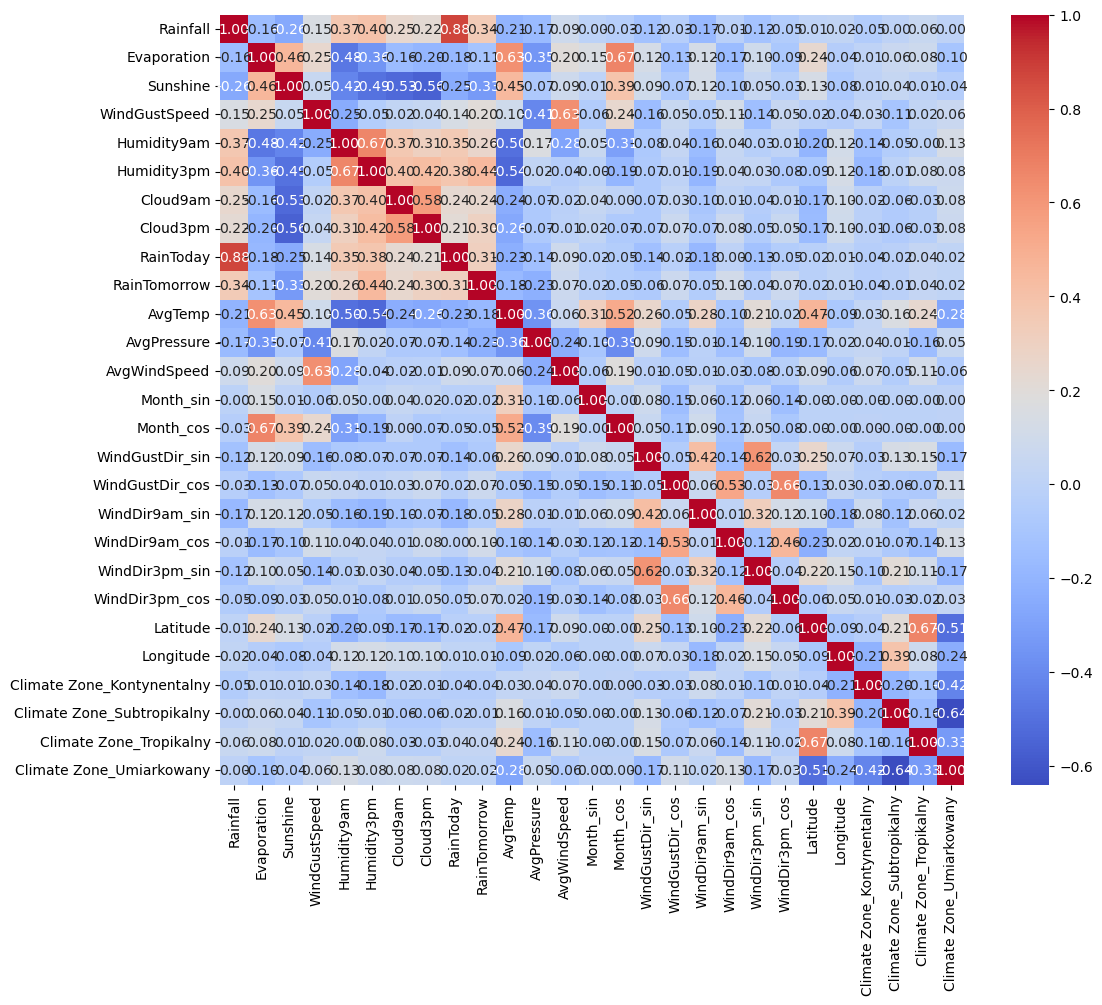

In [60]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

Walka z modelem:((((

In [61]:
df.columns

Index(['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Humidity9am',
       'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow',
       'AvgTemp', 'AvgPressure', 'AvgWindSpeed', 'Month_sin', 'Month_cos',
       'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'Latitude',
       'Longitude', 'Climate Zone_Kontynentalny', 'Climate Zone_Subtropikalny',
       'Climate Zone_Tropikalny', 'Climate Zone_Umiarkowany'],
      dtype='object')

In [62]:
from sklearn.preprocessing import StandardScaler
#wywalilam month 

features = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Humidity9am',
       'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'AvgTemp', 'AvgPressure', 'AvgWindSpeed', 'Month_sin',
       'Month_cos', 'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'Climate Zone_Kontynentalny', 'Climate Zone_Subtropikalny',
       'Climate Zone_Tropikalny', 'Climate Zone_Umiarkowany']

target = 'RainTomorrow'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21897
           1       0.76      0.49      0.60      6261

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158



In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

features = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Humidity9am',
       'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'AvgTemp', 'AvgPressure', 'AvgWindSpeed', 'Month_sin',
       'Month_cos', 'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'Climate Zone_Kontynentalny', 'Climate Zone_Subtropikalny',
       'Climate Zone_Tropikalny', 'Climate Zone_Umiarkowany']

target = 'RainTomorrow'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     21897
           1       0.71      0.49      0.58      6261

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158

